# Exercise: Optimizing mixing temperature

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gpytorch

## Create the dataset

In [2]:
unnormalized_temperatures = np.array([192.08, 258.30, 187.24, 188.54])
mean_T, std_T = np.mean(unnormalized_temperatures), np.std(unnormalized_temperatures)
normalized_temperatures = (unnormalized_temperatures - mean_T) / std_T

In [3]:
mixing_percentages_train = np.array([
    [0.50, 0.50, 0.00, 0.00],
    [0.33, 0.33, 0.33, 0.00],
    [0.00, 0.50, 0.50, 0.00],
    [0.00, 0.33, 0.33, 0.33]
])

In [4]:
# Create a grid of values between 0 and 1 with an increment of 0.01
x = torch.arange(0, 1.01, 0.01)
y = torch.arange(0, 1.01, 0.01)

# Create the meshgrid
X, Y = torch.meshgrid(x, y)

# Create the mixing_percentages_test tensor
mixing_percentages_test = torch.stack([X, Y, torch.zeros_like(X), torch.zeros_like(Y)], dim=-1)

/home/vscode/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
def unnormalize_temperatures(temperatures, mean, std):
    return temperatures * std + mean

In [6]:
normalized_temperatures = torch.tensor(normalized_temperatures)
mixing_percentages_train = torch.tensor(mixing_percentages_train)

## Fit Gaussian process to the training data

In [7]:
class GaussianProcess(gpytorch.models.ExactGP):
    def __init__(self,
                 train_x,
                 train_y,
                 likelihood,
                 lengthscale=1.0,
                 likelihood_noise=1e-4
                ):
        super(GaussianProcess, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()
        self.covar_module.lengthscale = lengthscale
        self.likelihood.noise = likelihood_noise

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Predictive distribution before any data is observed

In [8]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GaussianProcess(None, None, likelihood)

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [9]:
with torch.no_grad():
    predictive_distribution = likelihood(model(mixing_percentages_test))
    predictive_mean = predictive_distribution.mean
    predictive_stddev = predictive_distribution.stddev

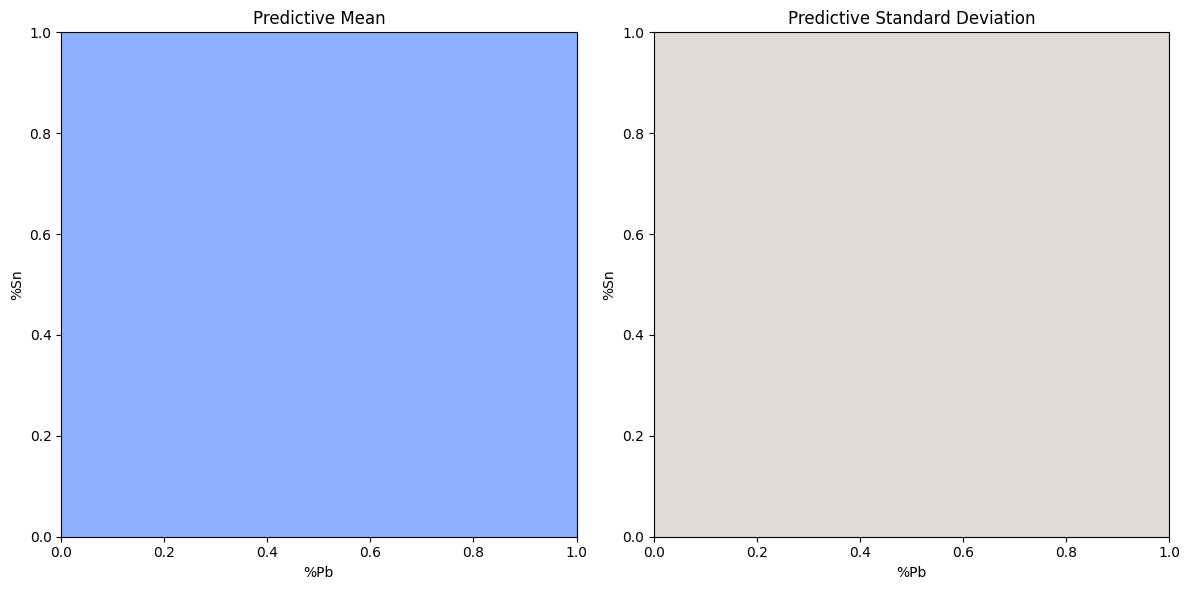

In [10]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the predictive mean
axs[0].contourf(X, Y, predictive_mean.numpy(), levels=20, cmap='coolwarm')
axs[0].set_title('Predictive Mean')
axs[0].set_xlabel('%Pb')
axs[0].set_ylabel('%Sn')

# Plot the predictive standard deviation
axs[1].contourf(X, Y, predictive_stddev.numpy(), levels=20, cmap='coolwarm')
axs[1].set_title('Predictive Standard Deviation')
axs[1].set_xlabel('%Pb')
axs[1].set_ylabel('%Sn')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Predictive distribution after data is observed

In [11]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GaussianProcess(mixing_percentages_train, normalized_temperatures, likelihood)

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [12]:
with torch.no_grad():
    predictive_distribution = likelihood(model(mixing_percentages_test))
    predictive_mean = predictive_distribution.mean
    predictive_stddev = predictive_distribution.stddev

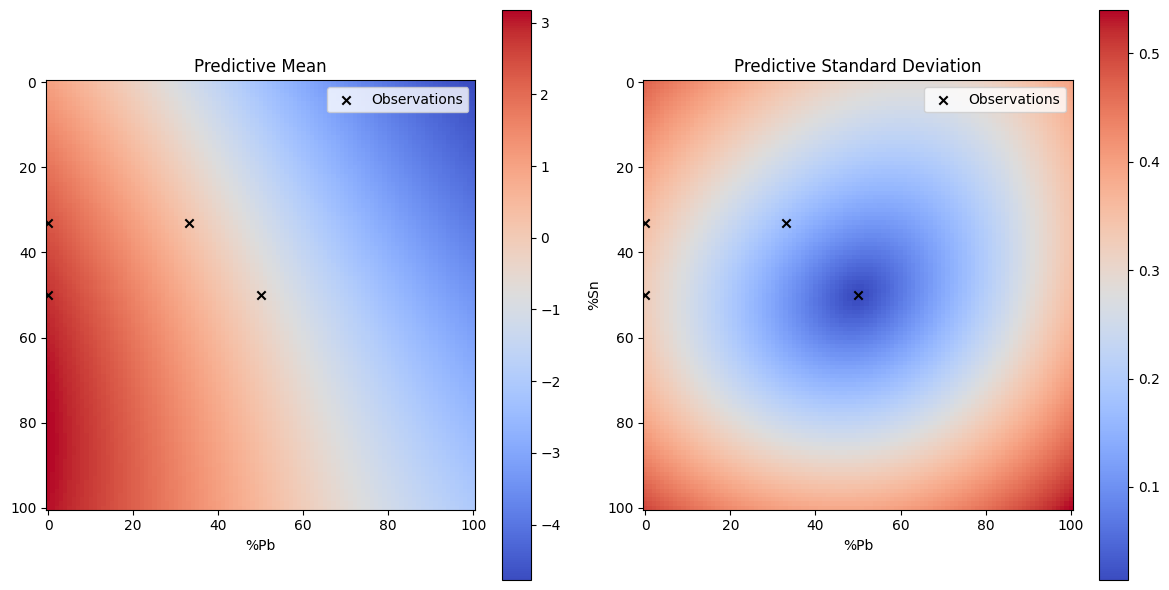

In [13]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the predictive mean
im1 = axs[0].imshow(predictive_mean.numpy(), cmap='coolwarm')
axs[0].set_title('Predictive Mean')
axs[0].set_xlabel('%Pb')

# Scatter plot for observed points
observed_points = np.array([(50, 50), (33, 33), (0, 50), (0, 33)])
axs[0].scatter(observed_points[:, 0], observed_points[:, 1], c='k', marker='x', label='Observations')

# Add legend for observations
axs[0].legend()

fig.colorbar(im1, ax=axs[0])

# Plot the predictive standard deviation
im2 = axs[1].imshow(predictive_stddev.numpy(), cmap='coolwarm')
axs[1].set_title('Predictive Standard Deviation')
axs[1].set_xlabel('%Pb')
axs[1].set_ylabel('%Sn')

# Scatter plot for observed points
axs[1].scatter(observed_points[:, 0], observed_points[:, 1], c='k', marker='x', label='Observations')

# Add legend for observations
axs[1].legend()

fig.colorbar(im2, ax=axs[1])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
